In [1]:
!pip install -q googletrans
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score, roc_auc_score
from PIL import Image
import os
import re

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Load text data into memory

In [2]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [3]:
print(train1.shape)
train1.head()

(223549, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print(train2.shape)
train2.head()

(1902194, 45)


,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,haha you guys are a bunch of losers.,1,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
print(valid.shape)
valid.head()

(8000, 4)


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [6]:
print(test.shape)
test.head()

(63812, 3)


,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


0    202165
1     21384
Name: toxic, dtype: int64


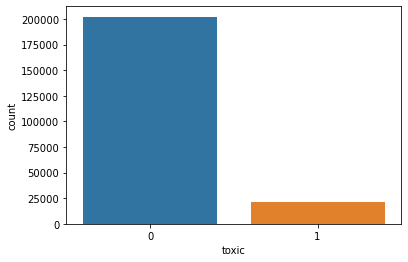

In [7]:
print(train1.toxic.value_counts())
sns.countplot(train1.toxic)

0    1789968
1     112226
Name: toxic, dtype: int64


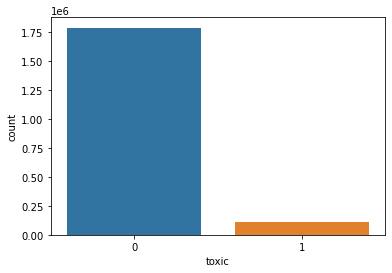

In [8]:
print(train2.toxic.value_counts())
sns.countplot(train2.toxic)

0    6770
1    1230
Name: toxic, dtype: int64


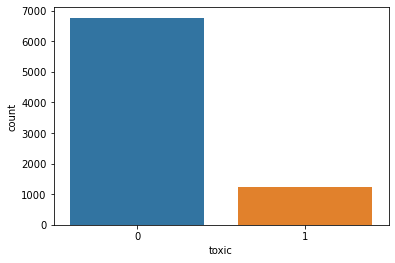

In [9]:
print(valid.toxic.value_counts())
sns.countplot(valid.toxic)

tr    3000
es    2500
it    2500
Name: lang, dtype: int64


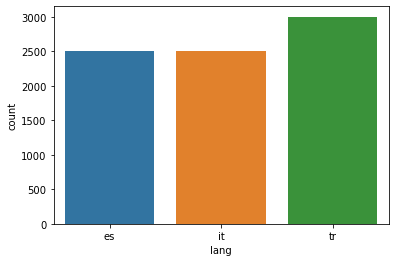

In [10]:
print(valid.lang.value_counts())
sns.countplot(valid.lang)

tr    14000
pt    11012
ru    10948
fr    10920
it     8494
es     8438
Name: lang, dtype: int64


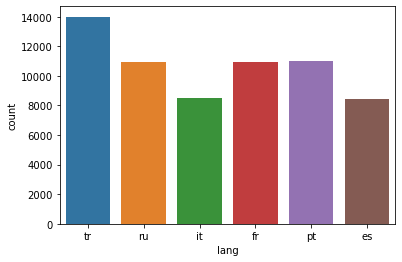

In [11]:
print(test.lang.value_counts())
sns.countplot(test.lang)

In [12]:
# Combine train1 with a subset of train2
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])

In [13]:
def get_ax(rows=1, cols=2, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return fig, ax

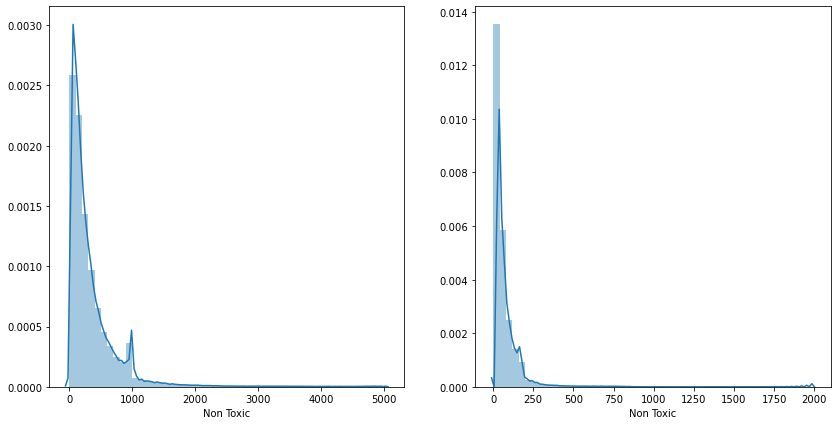

In [14]:
fig, ax = get_ax()

sns.distplot(train[train['toxic']==0]['comment_text'].str.len(), axlabel="Non Toxic", ax=ax[0])
sns.distplot(train[train['toxic']==0]['comment_text'].str.split().str.len(), axlabel="Non Toxic", ax=ax[1])

fig.show()

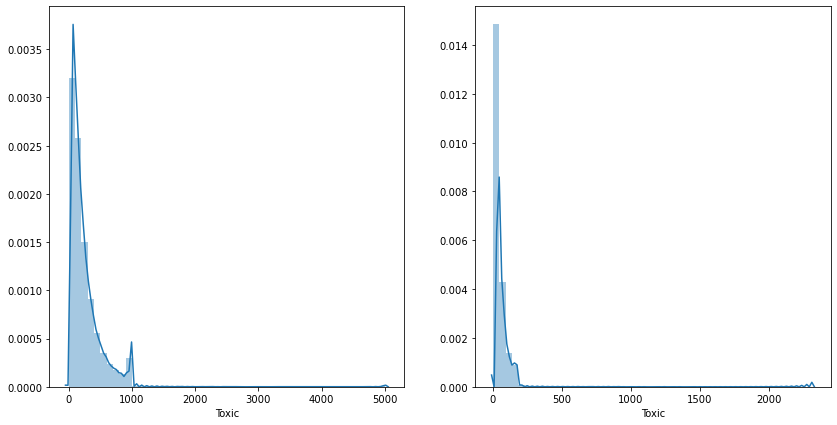

In [15]:
fig, ax = get_ax()

sns.distplot(train[train['toxic']==1]['comment_text'].str.len(), axlabel="Toxic", ax=ax[0])
sns.distplot(train[train['toxic']==1]['comment_text'].str.split().str.len(), axlabel="Toxic", ax=ax[1])

fig.show()

In [16]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, clean_mask, title = None):
    wordcloud = WordCloud(
        background_color='black',
        mask=clean_mask,
        stopwords=stopwords,
        max_words=2000,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [17]:
clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
clean_mask=clean_mask[:,:,1]

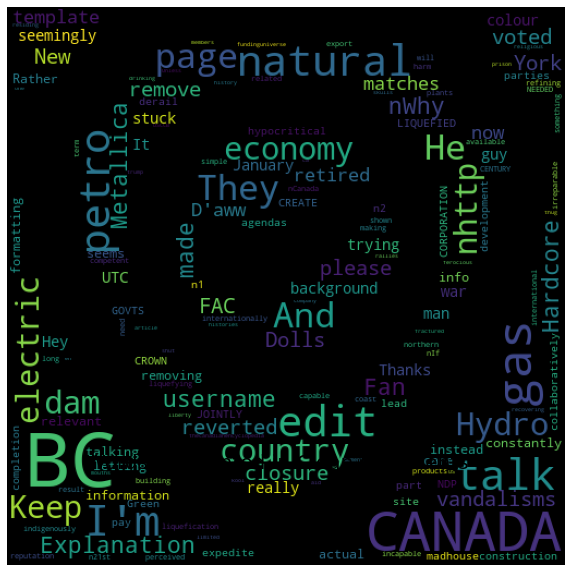

In [18]:
show_wordcloud(train.query("toxic == 0").comment_text.values, clean_mask, 
               title = 'Words frequented in Clean Comments')

In [19]:
clean_mask=np.array(Image.open("../input/imagesforkernal/toxic-sign.png"))
clean_mask=clean_mask[:,:,1]

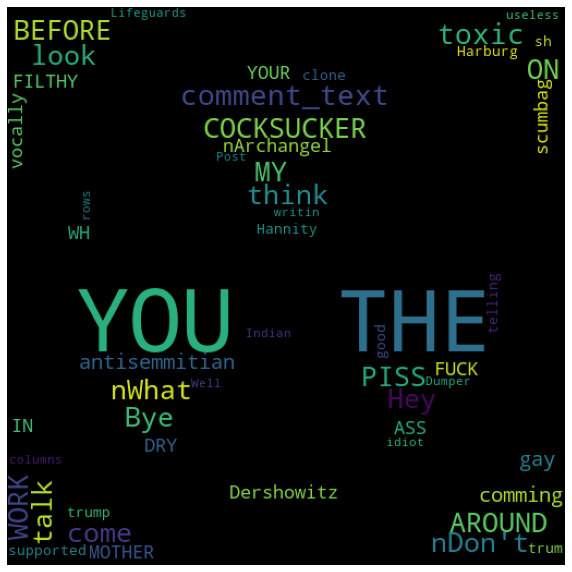

In [20]:
show_wordcloud(train.query("toxic == 1"), clean_mask,
               title = 'Words frequented in Toxic Comments')

## TPU Configs

In [21]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Helper Functions

In [22]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [23]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
AUTO = tf.data.experimental.AUTOTUNE




# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

## Create tokenizer

In [25]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')


In [26]:
x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

In [27]:
y_train = train.toxic.values
y_valid = valid.toxic.values

## Build datasets objects

In [28]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

## Load model into the TPU

In [29]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 192, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
CPU times: user 35.9 s, sys: 10 s, total: 45.9 s
Wall time: 1min 3s


## Train Model

In [30]:
matplotlib.rcParams['figure.figsize'] = (12, 10)

In [31]:
def plot_metrics(history, val=True):
    metrics =  ['accuracy', 'auc', 'precision', 'recall']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        if val:
            plt.plot(history.epoch, history.history['val_' + metric],
                     color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])

        plt.legend()

First, we train on the subset of the training set, which is completely in English.

In [32]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3
3795/3795 [==============================] - 368s 97ms/step - accuracy: 0.9744 - loss: 0.0656 - val_accuracy: 0.8440 - val_loss: 0.3643
Epoch 2/3
3795/3795 [==============================] - 357s 94ms/step - accuracy: 0.9802 - loss: 0.0501 - val_accuracy: 0.8475 - val_loss: 0.5001
Epoch 3/3
3795/3795 [==============================] - 357s 94ms/step - accuracy: 0.9827 - loss: 0.0435 - val_accuracy: 0.8483 - val_loss: 0.4472


KeyError: 'auc'

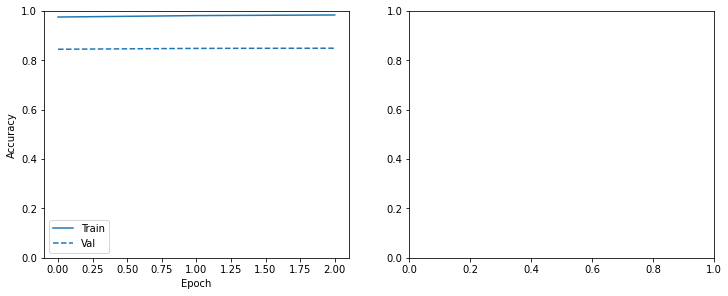

In [33]:
plot_metrics(train_history)

Now that we have pretty much saturated the learning potential of the model on english only data, we train it for one more epoch on the `validation` set, which is significantly smaller but contains a mixture of different languages.

In [34]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

Epoch 1/6
62/62 [==============================] - 6s 92ms/step - accuracy: 0.8630 - loss: 0.3109
Epoch 2/6
62/62 [==============================] - 6s 92ms/step - accuracy: 0.9083 - loss: 0.2018
Epoch 3/6
62/62 [==============================] - 6s 91ms/step - accuracy: 0.9480 - loss: 0.1258
Epoch 4/6
62/62 [==============================] - 6s 91ms/step - accuracy: 0.9724 - loss: 0.0710
Epoch 5/6
62/62 [==============================] - 6s 91ms/step - accuracy: 0.9798 - loss: 0.0541
Epoch 6/6
62/62 [==============================] - 6s 92ms/step - accuracy: 0.9704 - loss: 0.0733


KeyError: 'auc'

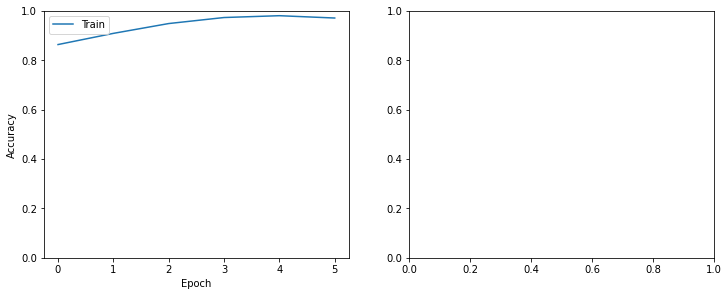

In [35]:
plot_metrics(train_history_2, val=False)

## Submission

In [36]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 16s 33ms/step
